### Data modeling of request orders

In [1]:
# Importing all the necessary libraries
import numpy as np              # Numerical array manipulation
import matplotlib.pyplot as plt # Plotting capabilities
import pymc3 as pm              # Python Monte Carlo Markov Chain package
import functionES as es         # Customized functions for this project
import seaborn as sns           # Fancy plot visualizations
import arviz as az
sns.set()
# import theano.tensor as tt

#  Loading data
datos = es.importing_data('OTs_detallado.sql', 7,1)

# Filtering data to keep the request orders finished
datosObservados = es.process_filter(datos)# Advanced process mining filtering
count_obs = len(datosObservados)# How many observations we have

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [24]:
count_obs

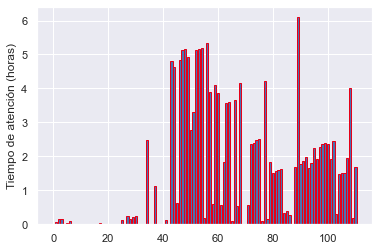

In [25]:
f = plt.figure()
ax1 = f.add_subplot(1,1,1)

ax1.bar(np.arange(len(datosObservados)),datosObservados.TiempoAtencion, edgecolor = "#E60018")
ax1.yaxis.set_label_text("Tiempo de atención (horas)")
plt.show()

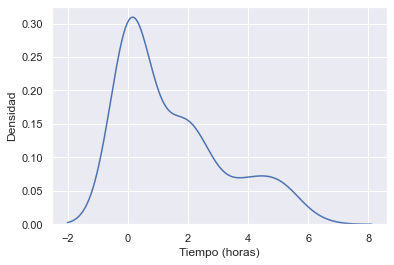

In [26]:
sns.kdeplot(datosObservados.TiempoAtencion)
plt.xlabel("Tiempo (horas)")
plt.ylabel("Densidad")
plt.show()

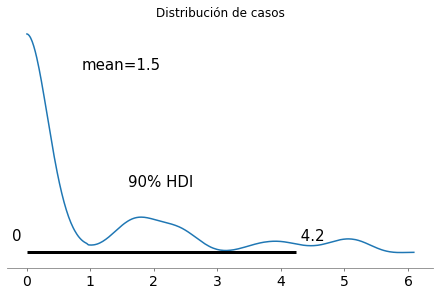

In [5]:
pm.plot_posterior(datosObservados.TiempoAtencion.to_numpy(), hdi_prob = 0.9)
plt.title("Distribución de casos")
plt.show()

In [6]:
# Generating Model context
with pm.Model() as model:
    alpha = 1.0/(datosObservados.TiempoAtencion).mean()
    
    lambda_1 = pm.Exponential("lambda_1", alpha)
#     lambda_2 = pm.Exponential("lambda_2", alpha)

#     tau = pm.DiscreteUniform("tau", lower=0, upper=count_obs-1)

# Generating lambdas (two because at some point, lambda changes its value)
with model:
    idx = np.arange(count_obs)
    lambda_ = lambda_1 #pm.math.switch(tau > idx, lambda_1, lambda_2)
    
# Generation Observation distribution
with model:
    observation = pm.Poisson("obs", lambda_, observed = datosObservados.TiempoAtencion)
    
# Generating simulations
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, step = step, progressbar = True)
    
lambda_1_samples = trace['lambda_1']
# lambda_2_samples = trace['lambda_2']
# tau_samples = trace['tau']

<ipython-input-6-f825a84603f0>:22: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000, step = step, progressbar = True)
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [lambda_1]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 341 seconds.
The number of effective samples is smaller than 25% for some parameters.


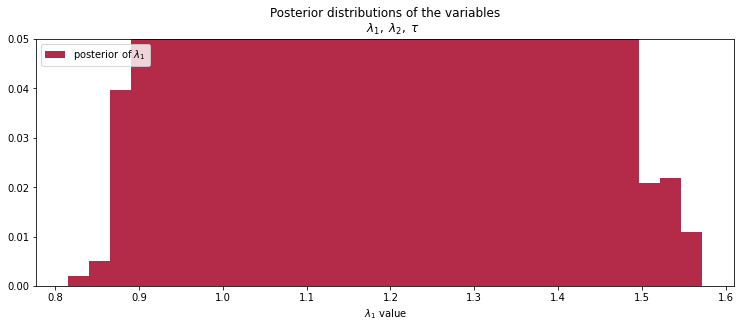

In [9]:
plt.subplots(figsize = (12.5, 10))
#histogram of the samples:

ax = plt.subplot(211)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variable
    $\lambda_1,\""")
# plt.xlim([15, 30])
plt.ylim([0,0.05])
plt.xlabel("$\lambda_1$ value")

plt.show()

C:\Users\430008252\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


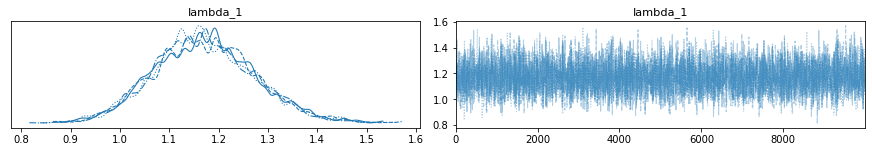

In [10]:
az.plot_trace(trace)
plt.show()

In [11]:
pm.summary(trace)

C:\Users\430008252\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda_1,1.172,0.102,0.983,1.364,0.001,0.001,6144.0,6030.0,1.0


In [12]:
with model:
    posterior_predictive= pm.fast_sample_posterior_predictive(trace)

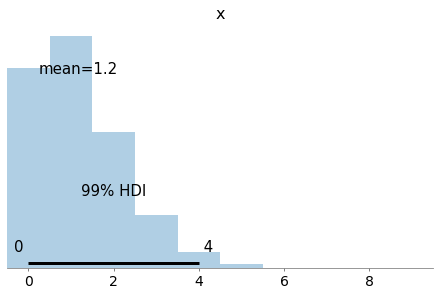

In [13]:
az.plot_posterior(posterior_predictive["obs"][:,0], hdi_prob = 0.99)
plt.show()

C:\Users\430008252\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


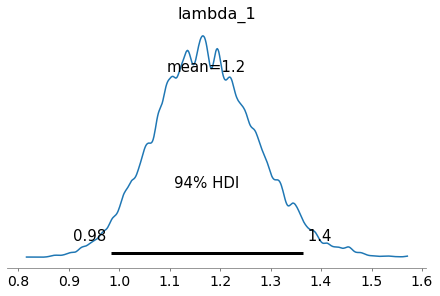

In [14]:
az.plot_posterior(trace)
plt.show()

C:\Users\430008252\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


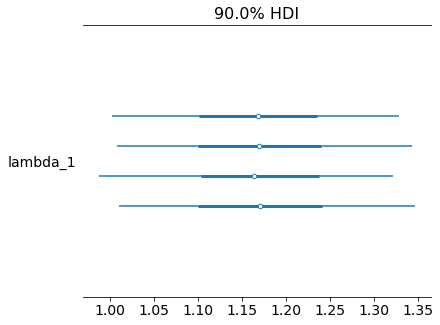

In [15]:
az.plot_forest(trace, hdi_prob = 0.9)
plt.show()

In [16]:
values = az.hdi(trace, hdi_prob = 0.9)
print(values)

C:\Users\430008252\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<xarray.Dataset>
Dimensions:   (hdi: 2)
Coordinates:
  * hdi       (hdi) <U6 'lower' 'higher'
Data variables:
    lambda_1  (hdi) float64 1.005 1.34


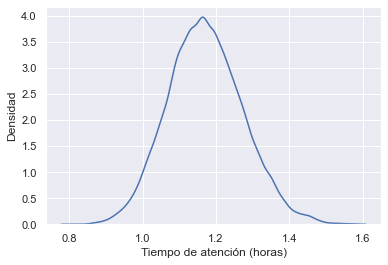

In [28]:
sns.kdeplot(lambda_1_samples)
plt.xlabel("Tiempo de atención (horas)")
plt.ylabel("Densidad")
plt.show()